# Project 2 - Task 2.1 Notebook


In [54]:
import cv2
import sns
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import warnings
import torch
from ultralytics import YOLO
from transformers import pipeline
from torchvision.datasets import VOCDetection
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from transformers import RTDetrForObjectDetection, RTDetrImageProcessor
from transformers import DetrForObjectDetection, DetrImageProcessor
import pandas as pd

In [55]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [56]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device", device)

Using device cuda:0


In [57]:
# Mapping between class IDs and labels

label2id = {'Plastic bag & wrapper': 0,
  'Cigarette': 1,
  'Bottle': 2,
  'Bottle cap': 3,
  'Can': 4,
  'Carton': 5}

id2label = {v: k for k, v in label2id.items()}
label2id, id2label
categories = list(id2label.values())

image_size = 480
checkpoint_rtdetr = "PekingU/rtdetr_r50vd"

In [58]:
from transformers import AutoImageProcessor

# Instantiate the image processor
image_processor = AutoImageProcessor.from_pretrained(
    checkpoint_rtdetr,
    do_resize=True,     # Resize the images to the expected size
    size={"width": image_size, "height": image_size},
    use_fast=True,      # Use the fast version of the processor
)

In [59]:
from taco_dataset import TACODETRDetectionDataset
train_dataset = TACODETRDetectionDataset(
    img_folder="/home/jb/Desktop/Projects/CV/cv-project2/taco",
    ann_file="/home/jb/Desktop/Projects/CV/cv-project2/taco/annotations_train.json",
    processor=image_processor,
)

validation_dataset = TACODETRDetectionDataset(
    img_folder="/home/jb/Desktop/Projects/CV/cv-project2/taco",
    ann_file="/home/jb/Desktop/Projects/CV/cv-project2/taco/annotations_val.json",
    processor=image_processor,
)

test_dataset = TACODETRDetectionDataset(
    img_folder="/home/jb/Desktop/Projects/CV/cv-project2/taco",
    ann_file="/home/jb/Desktop/Projects/CV/cv-project2/taco/annotations_test.json",
    processor=image_processor,
)


# Inpsect a sample from the training dataset
train_dataset[0]

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


{'pixel_values': tensor([[[0.2784, 0.3059, 0.3373,  ..., 0.1333, 0.1373, 0.1176],
          [0.3294, 0.3059, 0.3098,  ..., 0.1216, 0.1255, 0.1216],
          [0.3294, 0.3216, 0.3176,  ..., 0.1176, 0.1333, 0.1098],
          ...,
          [0.2549, 0.2745, 0.2667,  ..., 0.4471, 0.4627, 0.4510],
          [0.2824, 0.2706, 0.2706,  ..., 0.4196, 0.4078, 0.4039],
          [0.3137, 0.2863, 0.3255,  ..., 0.4510, 0.4196, 0.4039]],
 
         [[0.1451, 0.1725, 0.2039,  ..., 0.1059, 0.1137, 0.0902],
          [0.1961, 0.1765, 0.1843,  ..., 0.1020, 0.1059, 0.1020],
          [0.2039, 0.2000, 0.1961,  ..., 0.1020, 0.1137, 0.0902],
          ...,
          [0.2235, 0.2392, 0.2275,  ..., 0.3882, 0.4039, 0.3922],
          [0.2392, 0.2275, 0.2275,  ..., 0.3608, 0.3529, 0.3490],
          [0.2627, 0.2392, 0.2824,  ..., 0.4039, 0.3725, 0.3569]],
 
         [[0.1412, 0.1647, 0.1961,  ..., 0.1373, 0.1412, 0.1216],
          [0.1922, 0.1686, 0.1725,  ..., 0.1255, 0.1294, 0.1255],
          [0.1961, 0.188

In [60]:
from collections import Counter
train_classes = [label2id for _, label2id in train_dataset]
#n_samples = Counter(train_classes)

for i in range (3):
    sample = train_dataset[i]
    label = sample['labels']['class_labels']

    print(label)

tensor([2])
tensor([5, 5])
tensor([2, 3])


In [68]:
def get_coco_stats(dataset, split, id2label=None):
    coco = dataset.coco_dataset.coco
    ann_ids = coco.getAnnIds()
    anns = coco.loadAnns(ann_ids)

    cat_ids = [ann['category_id'] for ann in anns]
    names = [id2label[c] for c in cat_ids]

    return pd.DataFrame({'Class': names, 'Split': split})


In [69]:
df_train = get_coco_stats(train_dataset, 'Train', id2label)
df_val = get_coco_stats(validation_dataset, 'Validation', id2label)
df_test = get_coco_stats(test_dataset, 'Test', id2label)

df = pd.concat([df_train, df_val, df_test])
stats = df.groupby(['Class', 'Split']).size().reset_index(name='Count')


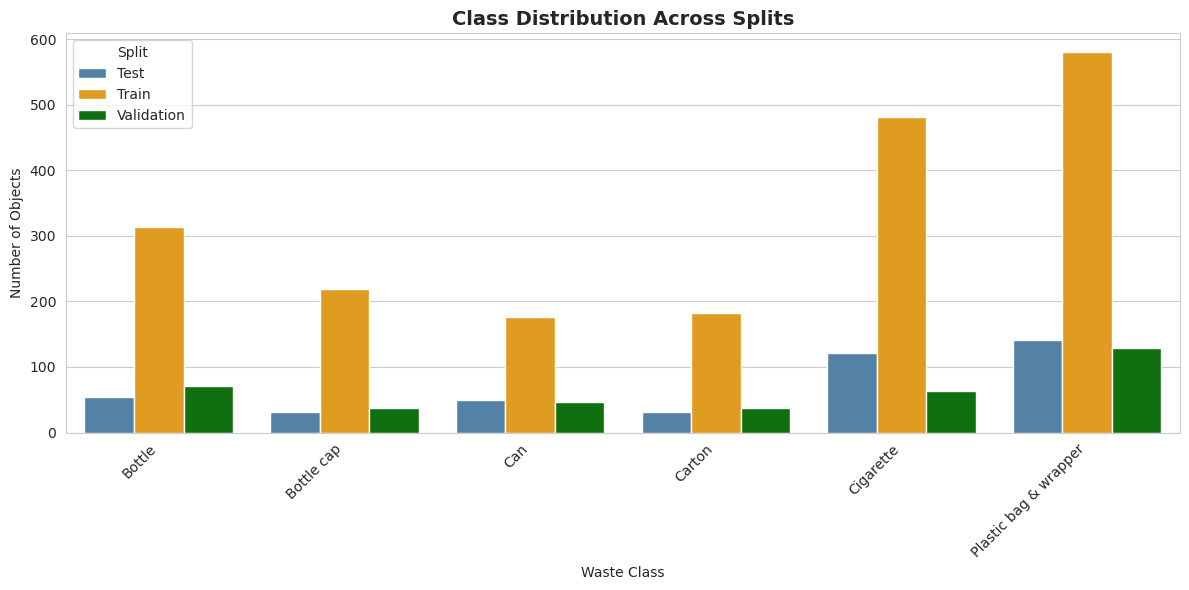

In [71]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=stats,
    x='Class',
    y='Count',
    hue='Split',
    palette=['steelblue', 'orange', 'green']
)
plt.title('Class Distribution Across Splits', fontsize=14, fontweight='bold')
plt.ylabel('Number of Objects')
plt.xlabel('Waste Class')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Split')
plt.tight_layout()
plt.show()

Image tensor shape: torch.Size([3, 480, 480])


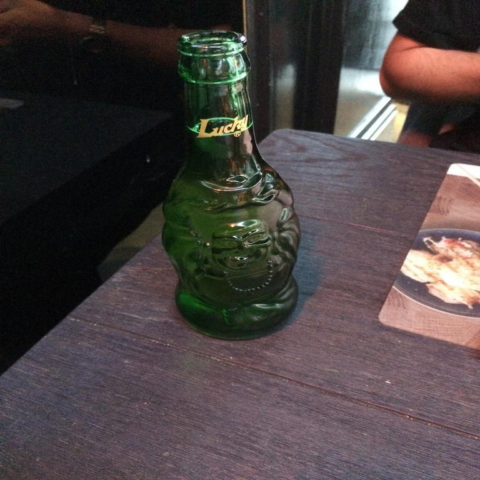

Image tensor shape: torch.Size([3, 480, 480])


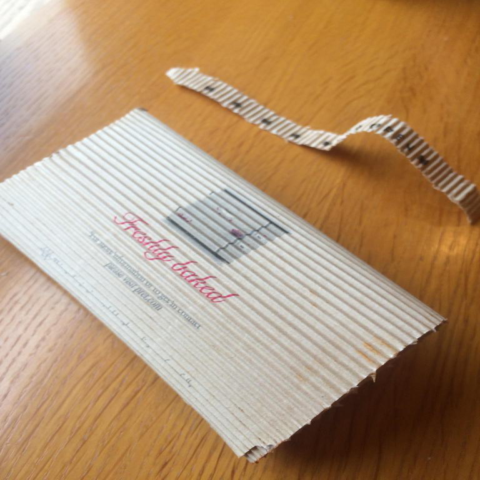

Image tensor shape: torch.Size([3, 480, 480])


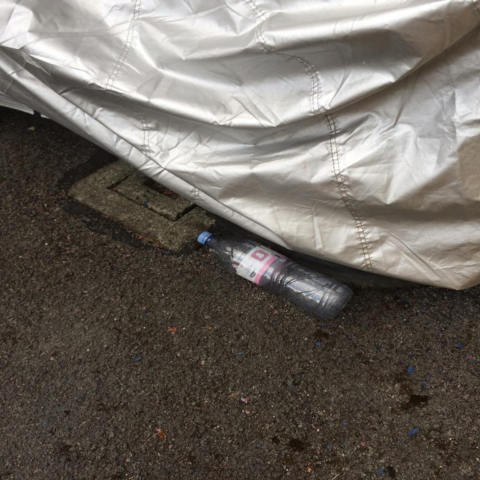

Image tensor shape: torch.Size([3, 480, 480])


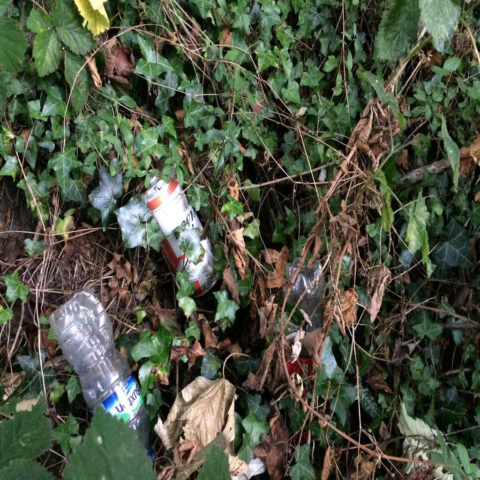

Image tensor shape: torch.Size([3, 480, 480])


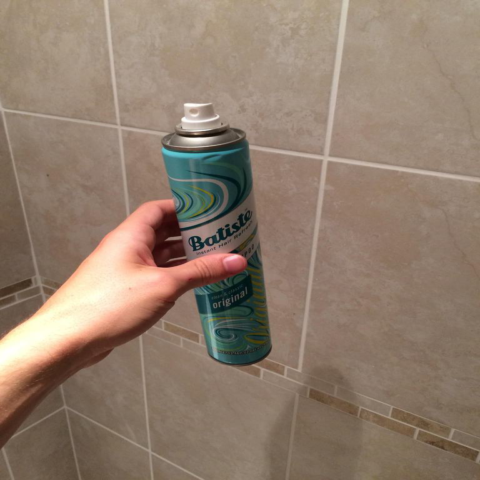

Image tensor shape: torch.Size([3, 480, 480])


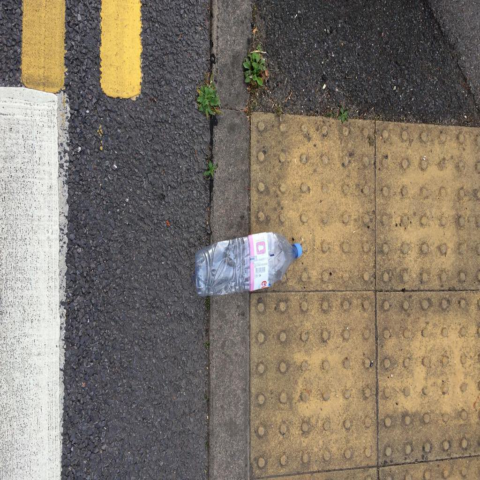

Image tensor shape: torch.Size([3, 480, 480])


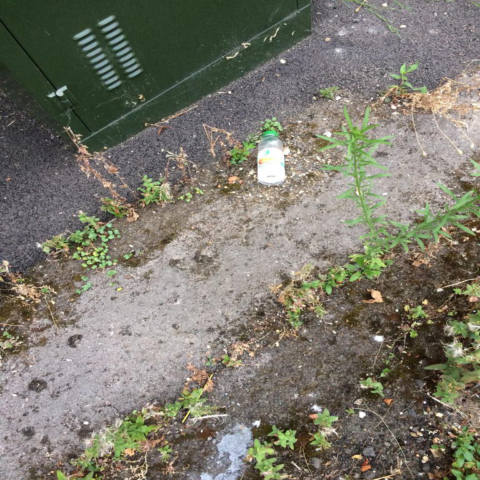

Image tensor shape: torch.Size([3, 480, 480])


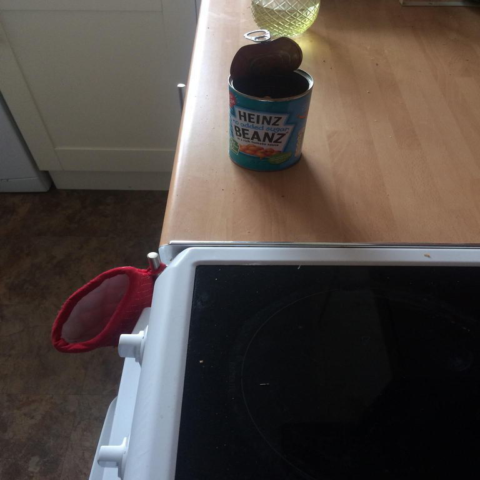

In [36]:
from PIL import ImageDraw

for i in range(8):
    sample = train_dataset[i]

    # De-normalize image
    image = sample["pixel_values"]
    print("Image tensor shape:", image.shape)
    image = image.numpy().transpose(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min()) * 255.
    image = Image.fromarray(image.astype(np.uint8))

    # Convert boxes from [center_x, center_y, width, height] to [x, y, width, height] for visualization
    # boxes = sample["labels"]["boxes"].numpy()
    # print("Boxes shape:", boxes.shape)
    # boxes[:, :2] = boxes[:, :2] - boxes[:, 2:] / 2
    # w, h = image.size
    # boxes = boxes * np.array([w, h, w, h])[None]
    #
    # categories = sample["labels"]["class_labels"].numpy()
    # print("Categories shape:", categories.shape)

    # Draw boxes and labels on image
    # draw = ImageDraw.Draw(image)
    # for box, category in zip(boxes, categories):
    #     x, y, w, h = box
    #     draw.rectangle([x, y, x + w, y + h], outline="red", width=1)
    #     draw.text((x, y), id2label[category], fill="white")

    display(image)

In [20]:
# dataset = VOCDetection('data/', year="2007", image_set="val", download=False)
# subset_size = 1000
# subset = [dataset[i] for i in range(subset_size)]
#
# # Mapping VOC classes to IDs
# VOC_CLASSES = [
#     "aeroplane", "bicycle", "bird", "boat", "bottle",
#     "bus", "car", "cat", "chair", "cow",
#     "diningtable", "dog", "horse", "motorbike", "person",
#     "pottedplant", "sheep", "sofa", "train", "tvmonitor"
# ]
# VOC_CLASS_TO_ID = {cls_name: idx + 1 for idx, cls_name in enumerate(VOC_CLASSES)}

In [21]:
# -----------------------------
# Prepare targets in TorchMetrics format
# -----------------------------
targets_list = []
for img, target in subset:
    objs = target['annotation']['object']
    if not isinstance(objs, list):
        objs = [objs]
    boxes = []
    labels = []
    for obj in objs:
        b = obj['bndbox']
        boxes.append([int(b['xmin']), int(b['ymin']), int(b['xmax']), int(b['ymax'])])
        labels.append(VOC_CLASS_TO_ID[obj['name']])
    targets_list.append({
        "boxes": torch.tensor(boxes, dtype=torch.float32),
        "labels": torch.tensor(labels, dtype=torch.int64)
    })
targets_list

[{'boxes': tensor([[263., 211., 324., 339.],
          [165., 264., 253., 372.],
          [  5., 244.,  67., 374.],
          [241., 194., 295., 299.],
          [277., 186., 312., 220.]]),
  'labels': tensor([9, 9, 9, 9, 9])},
 {'boxes': tensor([[141.,  50., 500., 330.]]), 'labels': tensor([7])},
 {'boxes': tensor([[ 69., 172., 270., 330.],
          [150., 141., 229., 284.],
          [285., 201., 327., 331.],
          [258., 198., 297., 329.]]),
  'labels': tensor([13, 15, 15, 15])},
 {'boxes': tensor([[ 92.,  72., 305., 473.]]), 'labels': tensor([2])},
 {'boxes': tensor([[231.,  88., 483., 256.],
          [ 11., 113., 266., 259.]]),
  'labels': tensor([8, 8])},
 {'boxes': tensor([[ 33., 148., 371., 416.]]), 'labels': tensor([7])},
 {'boxes': tensor([[  1., 235., 182., 388.],
          [210.,  36., 336., 482.],
          [ 46.,  82., 170., 365.],
          [ 11., 181., 142., 419.]]),
  'labels': tensor([12, 15, 15, 15])},
 {'boxes': tensor([[196., 165., 489., 247.]]), 'labels': t

In [22]:
def convert_yolo_predictions(yolo_results, coco_classes, voc_map):
    yolo_boxes = torch.tensor(yolo_results.boxes.xyxy, dtype=torch.float32)
    yolo_scores = torch.tensor(yolo_results.boxes.conf, dtype=torch.float32)

    # Convert YOLO class indices → names → VOC ids
    labels_list = []
    for label_idx in yolo_results.boxes.cls:
        name = coco_classes[label_idx.item()]
        label_id = voc_map.get(name, 0)
        labels_list.append(label_id)

    yolo_labels = torch.tensor(labels_list, dtype=torch.int64)

    return {
        "boxes": yolo_boxes,
        "scores": yolo_scores,
        "labels": yolo_labels,
    }


def convert_detr_predictions(detr_results, coco_classes, voc_map):
    #detr_results = [r for r in detr_results if r["score"] >= confidence]

    labels_list = []
    for l in detr_results["labels"]:
        name = coco_classes[l.item()]
        label_id = voc_map.get(name, 0)
        labels_list.append(label_id)

    return {
        "boxes": detr_results['boxes'],
        "scores": detr_results['scores'],
        "labels": torch.tensor(labels_list, dtype=torch.int64)
    }


def convert_rtdetr_predictions(rtdetr_results, coco_classes, voc_map):
    labels_list = []
    for l in rtdetr_results["labels"]:
        name = coco_classes[l.item()]
        label_id = voc_map.get(name, 0)
        labels_list.append(label_id)

    return {
        "boxes": rtdetr_results['boxes'],
        "scores": rtdetr_results['scores'],
        "labels": torch.tensor(labels_list, dtype=torch.int64)
    }

In [23]:
def evaluate_yolo(yolo_model, subset, targets_list, voc_map, conf):
    metric_yolo = MeanAveragePrecision()

    for sample, target in zip(subset, targets_list):
        img = sample[0]
        img_np = np.array(img)
        yolo_raw = yolo_model(img_np, conf=conf, verbose=False)[0]
        yolo_preds = convert_yolo_predictions(yolo_raw, yolo_model.names, voc_map)
        metric_yolo.update([yolo_preds], [target])

    return metric_yolo.compute()


def evaluate_detr(detr_processor, detr_model, subset, targets_list, voc_map, conf):
    metric_detr = MeanAveragePrecision()

    for sample, target in zip(subset, targets_list):
        img = sample[0]
        img_np = np.array(img)

        inputs = detr_processor(images=img_np, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = detr_model(**inputs)

        height, width = img_np.shape[:2]

        detr_raw = detr_processor.post_process_object_detection(
            outputs, target_sizes=[(height, width)], threshold=conf)[0]

        detr_preds = convert_detr_predictions(detr_raw, detr_model.config.id2label, voc_map)

        metric_detr.update([detr_preds], [target])

    return metric_detr.compute()


def evaluate_rtdetr(rtdetr_image_processor, rtdetr_model, subset, targets_list, voc_map, conf):
    metric_rtdetr = MeanAveragePrecision()

    for sample, target in zip(subset, targets_list):
        img = sample[0]
        img_np = np.array(img)

        inputs = rtdetr_image_processor(img_np, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = rtdetr_model(**inputs)

        height, width = img_np.shape[:2]
        rtdetr_raw = rtdetr_image_processor.post_process_object_detection(
            outputs, target_sizes=[(height, width)], threshold=conf
        )[0]
        rtdetr_preds = convert_rtdetr_predictions(rtdetr_raw,
                                                  rtdetr_model.config.id2label, voc_map)
        metric_rtdetr.update([rtdetr_preds], [target])

    return metric_rtdetr.compute()

In [24]:
def print_metrics(results, confidence):
    for conf in confidence:
        print(f"Confidence Threshold: {conf} \n")

        for model_name in ['yolo', 'detr', 'rt-detr']:
            result = results[model_name][conf]

            print(f"\n{model_name.upper()} Metrics:")
            print(f"  mAP :  {result['map']:.4f}")
            print(f"  mAP@50:    {result['map_50']:.4f}")
            print(f"  mAP@75 :    {result['map_75']:.4f}")
            print(f"  mAP (small objects):  {result['map_small']:.4f}")
            print(f"  mAP (medium objects): {result['map_medium']:.4f}")
            print(f"  mAP (large objects):  {result['map_large']:.4f}")
            print(f"  mAR@1:                {result['mar_1']:.4f}")
            print(f"  mAR@10:               {result['mar_10']:.4f}")
            print(f"  mAR@100:              {result['mar_100']:.4f}")
            print(f"  mAR (small objects):  {result['mar_small']:.4f}")
            print(f"  mAR (medium objects): {result['mar_medium']:.4f}")
            print(f"  mAR (large objects):  {result['mar_large']:.4f}")

In [25]:
yolo_model = YOLO("yolo11s.pt").to(device)

detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(device)

rtdetr_image_processor = RTDetrImageProcessor.from_pretrained("PekingU/rtdetr_r50vd")
rtdetr_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd").to(device)

def evaluate_models(subset, targets_list, voc_map, confidence):
    results = {
        'yolo': {},
        'detr': {},
        'rt-detr': {}
    }

    for conf in confidence:
        results['yolo'][conf] = evaluate_yolo(yolo_model, subset, targets_list, voc_map, conf)
        results['detr'][conf] = evaluate_detr(detr_processor, detr_model, subset, targets_list, voc_map, conf)
        results['rt-detr'][conf] = evaluate_rtdetr(rtdetr_image_processor, rtdetr_model,
                                                   subset, targets_list, voc_map, conf)
    return results



/home/jb/anaconda3/envs/cv_labs/lib/python3.9/site-packages/torch/nn/modules/module.py:2400: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/jb/anaconda3/envs/cv_labs/lib/python3.9/site-packages/torch/nn/modules/module.py:2400: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/jb/anaconda3/envs/cv_labs/lib/python3.9/site-packages/torch/nn/modules/module.py:2400: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter 

In [26]:
confidence = [0.001, 0.05, 0.1, 0.3, 0.5]
results = evaluate_models(subset, targets_list, VOC_CLASS_TO_ID, confidence)

/tmp/ipykernel_49478/1997881637.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yolo_boxes = torch.tensor(yolo_results.boxes.xyxy, dtype=torch.float32)
/tmp/ipykernel_49478/1997881637.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yolo_scores = torch.tensor(yolo_results.boxes.conf, dtype=torch.float32)
/home/jb/anaconda3/envs/cv_labs/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable 

KeyboardInterrupt: 

In [ ]:
print_metrics(results, confidence)